# INSEE’s premises

In [1]:
import geopandas
import re
import pandas as pd
import pyproj
from shapely.ops import transform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, descartes

from pynsee.sirene import *
from pynsee.geodata import *

In [2]:
# Subscribe to api.insee.fr and get your credentials!
# Save your credentials with init_conn function :
# from pynsee.utils.init_conn import init_conn
# init_conn(insee_key="my_insee_key", insee_secret="my_insee_secret")

# Beware : any change to the keys should be tested after having cleared the cache
# Please do : from pynsee.utils import clear_all_cache; clear_all_cache()"

In [3]:
variable = ["denominationUniteLegale", 'sigleUniteLegale', 'categorieJuridiqueUniteLegale']

insee_pattern = "INSTITUT NATIONAL DE LA STATISTIQUE ET DES ETUDES ECONOMIQUES"

pattern = [insee_pattern, 'INSEE', '7120']
# 7120 : Service central d'un ministère

data = search_sirene(variable = variable, pattern = pattern, kind="siret")

Locally saved data has been used
Set update=True to trigger an update

In [4]:
df = data.get_location()

Getting location:   0%|                                                                                                                 | 0/37 [00:00<?, ?it/s]

Getting location:   3%|██▊                                                                                                      | 1/37 [00:00<00:07,  4.89it/s]

Getting location:   5%|█████▋                                                                                                   | 2/37 [00:00<00:12,  2.72it/s]

Getting location:   8%|████████▌                                                                                                | 3/37 [00:01<00:15,  2.27it/s]

Getting location:  11%|███████████▎                                                                                             | 4/37 [00:01<00:14,  2.30it/s]

Getting location:  14%|██████████████▏                                                                                          | 5/37 [00:02<00:15,  2.01it/s]

Getting location:  16%|█████████████████                                                                                        | 6/37 [00:02<00:14,  2.08it/s]

Getting location:  19%|███████████████████▊                                                                                     | 7/37 [00:03<00:17,  1.70it/s]

Getting location:  22%|██████████████████████▋                                                                                  | 8/37 [00:03<00:13,  2.13it/s]

Getting location:  24%|█████████████████████████▌                                                                               | 9/37 [00:04<00:13,  2.12it/s]

Getting location:  27%|████████████████████████████                                                                            | 10/37 [00:04<00:13,  2.00it/s]

Getting location:  30%|██████████████████████████████▉                                                                         | 11/37 [00:05<00:12,  2.10it/s]

Getting location:  32%|█████████████████████████████████▋                                                                      | 12/37 [00:06<00:14,  1.68it/s]

Getting location:  35%|████████████████████████████████████▌                                                                   | 13/37 [00:06<00:11,  2.10it/s]

Getting location:  38%|███████████████████████████████████████▎                                                                | 14/37 [00:06<00:11,  2.00it/s]

Getting location:  41%|██████████████████████████████████████████▏                                                             | 15/37 [00:07<00:13,  1.68it/s]

Getting location:  43%|████████████████████████████████████████████▉                                                           | 16/37 [00:08<00:11,  1.75it/s]

Getting location:  46%|███████████████████████████████████████████████▊                                                        | 17/37 [00:08<00:11,  1.74it/s]

Getting location:  49%|██████████████████████████████████████████████████▌                                                     | 18/37 [00:09<00:10,  1.86it/s]

Getting location:  51%|█████████████████████████████████████████████████████▍                                                  | 19/37 [00:09<00:09,  1.93it/s]

Getting location:  54%|████████████████████████████████████████████████████████▏                                               | 20/37 [00:10<00:09,  1.78it/s]

Getting location:  57%|███████████████████████████████████████████████████████████                                             | 21/37 [00:10<00:09,  1.78it/s]

Getting location:  59%|█████████████████████████████████████████████████████████████▊                                          | 22/37 [00:11<00:07,  2.04it/s]

Getting location:  62%|████████████████████████████████████████████████████████████████▋                                       | 23/37 [00:11<00:07,  1.91it/s]

Getting location:  65%|███████████████████████████████████████████████████████████████████▍                                    | 24/37 [00:12<00:06,  2.09it/s]

Getting location:  68%|██████████████████████████████████████████████████████████████████████▎                                 | 25/37 [00:12<00:06,  1.98it/s]

Getting location:  70%|█████████████████████████████████████████████████████████████████████████                               | 26/37 [00:13<00:05,  2.03it/s]

Getting location:  73%|███████████████████████████████████████████████████████████████████████████▉                            | 27/37 [00:13<00:04,  2.08it/s]

Getting location:  76%|██████████████████████████████████████████████████████████████████████████████▋                         | 28/37 [00:14<00:04,  1.84it/s]

Getting location:  78%|█████████████████████████████████████████████████████████████████████████████████▌                      | 29/37 [00:14<00:04,  1.79it/s]

Getting location:  81%|████████████████████████████████████████████████████████████████████████████████████▎                   | 30/37 [00:15<00:04,  1.60it/s]

Getting location:  84%|███████████████████████████████████████████████████████████████████████████████████████▏                | 31/37 [00:16<00:03,  1.75it/s]

Getting location:  86%|█████████████████████████████████████████████████████████████████████████████████████████▉              | 32/37 [00:16<00:02,  1.80it/s]

Getting location:  89%|████████████████████████████████████████████████████████████████████████████████████████████▊           | 33/37 [00:17<00:02,  1.83it/s]

Getting location:  92%|███████████████████████████████████████████████████████████████████████████████████████████████▌        | 34/37 [00:17<00:01,  1.93it/s]

Getting location:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▍     | 35/37 [00:18<00:01,  1.77it/s]

Getting location:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 36/37 [00:18<00:00,  1.85it/s]

Getting location: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.82it/s]

Getting location: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.91it/s]

In [5]:
def _convert_polygon(geo, crs_in='EPSG:4326', crs_out='EPSG:3857'):
    
    if geo is not None:
        crsIn = pyproj.CRS(crs_in)
        crsOut = pyproj.CRS(crs_out)

        project = pyproj.Transformer.from_crs(crsIn, crsOut, always_xy=True).transform
        geo_converted = transform(project, geo)

        return geo_converted

# convert openstreetmap data from crs 4326 to crs 3857
df['geometry'] = df['geometry'].apply(lambda x: _convert_polygon(x))

df["crs"] = 'EPSG:3857'

# move overseas departement closer to metropolitan France
df = df.translate()

# add a zoom on ile de France region
df = df.zoom()

Previously saved data has been used:
/home/jovyan/.cache/pynsee/pynsee/8c3c99e805b5ab67e7f1f8c6ec7e546f
Set update=True to get the most up-to-date data

Finding departement:   0%|                                                                                                              | 0/37 [00:00<?, ?it/s]

Finding departement:  27%|███████████████████████████▎                                                                         | 10/37 [00:00<00:00, 97.69it/s]

Finding departement:  73%|████████████████████████████████████████████████████████████████████████▉                           | 27/37 [00:00<00:00, 136.81it/s]

Finding departement: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 138.58it/s]

In [6]:
gdf = geopandas.GeoDataFrame(df).set_crs('EPSG:3857')
gdf = gdf.reset_index(drop=True)

for i in range(len(gdf.index)):
    gdf.loc[i,'name'] = str(i+1) + ' - ' + gdf.loc[i,'enseigne1Etablissement']
    gdf.loc[i,'i'] = i + 1
    
# cleaning
gdf = gdf[~gdf.geometry.isnull()]

In [7]:
geodataList =  get_geodata_list()
mapdep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')

# move overseas departement closer to metropolitan France
mapdep = mapdep.translate()
# add a zoom on ile de France region
mapdep = mapdep.zoom()

In [8]:
# conversion to geopandas df
mapdepgeo = geopandas.GeoDataFrame(mapdep).set_crs("EPSG:3857")
mapdepgeo.head()

,id,nom_m,nom,insee_dep,insee_reg,geometry,bbox,crs
0,DEPARTEM_GLP_00000000001,GUADELOUPE,Guadeloupe,971,01,"MULTIPOLYGON (((-739144.768 6296095.811, -7391...","[-6880639.76094451, 1785277.73400778, -6790707...",EPSG:3857
1,DEPARTEM_MTQ_00000000001,MARTINIQUE,Martinique,972,02,"MULTIPOLYGON (((-756752.387 6056818.795, -7567...","[-6815985.71107846, 1618842.96967012, -6769303...",EPSG:3857
2,DEPARTEM_REU_00000000001,LA REUNION,La Réunion,974,04,"MULTIPOLYGON (((-807378.564 5867965.281, -8072...","[6146675.55743685, -2438398.99690376, 6215705....",EPSG:3857
3,DEPARTEM_GUF_00000000001,GUYANE,Guyane,973,03,"MULTIPOLYGON (((-650783.613 5681770.336, -6507...","[-6078310.30343627, 235055.06017674, -5746205....",EPSG:3857
4,DEPARTEM_MYT_00000000001,MAYOTTE,Mayotte,976,06,"MULTIPOLYGON (((-553726.624 5453062.725, -5537...","[5011418.77897208, -1460351.156634, 5042772.00...",EPSG:3857


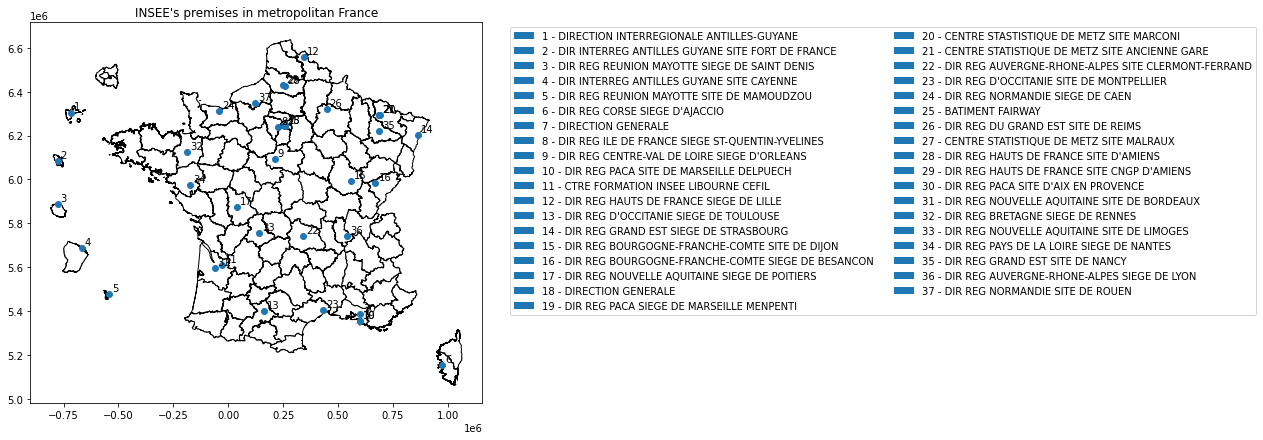

In [9]:
# plot
ax = mapdepgeo.plot(color='white', edgecolor='black', figsize = (15,7))

gdf.plot(ax=ax)
plt.title("INSEE's premises in metropolitan France")

for x, y, i, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.i, gdf.name):
    ax.annotate(int(i), xy=(x, y), xytext=(3, 3), textcoords="offset points")

legends = [mpatches.Patch(label=f) for f in gdf.name]
plt.legend(handles=legends, ncol=2, bbox_to_anchor=(1.05, 1))
plt.show()